# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from ast import literal_eval
from collections import Counter
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
import math
import copy
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('main_task.csv')

Описание датасета:

Restaurant_id — идентификационный номер ресторана / сети ресторанов
City — город, в котором находится ресторан
Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане
Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель)
Price Range — диапазон цен в ресторане
Number of Reviews — количество отзывов о ресторане; Reviews — данные о двух отзывах, которые отображаются на сайте ресторана
URL_TA — URL страницы ресторана на TripAdvisor
ID_TA — идентификатор ресторана в базе данных TripAdvisor

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [4]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA'],
      dtype='object')

In [5]:
# для удобства работы с данными переименуем столбцы
df.rename(columns={'Cuisine Style': 'Cuisine_Style', 'Price Range': 'Price_Range',
                   'Number of Reviews': 'Number_of_Reviews'}, inplace=True)

In [6]:
# посмотрим на пропуски по столбцам
df.isnull().sum().sort_values(ascending=False)

Price_Range          13886
Cuisine_Style         9283
Number_of_Reviews     2543
ID_TA                    0
URL_TA                   0
Reviews                  0
Rating                   0
Ranking                  0
City                     0
Restaurant_id            0
dtype: int64

In [7]:
df.sample(5)

,Restaurant_id,City,Cuisine_Style,Ranking,Rating,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA
28876,id_1678,London,"['Bar', 'British', 'Pub', 'Vegetarian Friendly...",1681.0,4.0,$$ - $$$,158.0,"[['Delicious Sunday roast', 'Great live music'...",/Restaurant_Review-g186338-d3568372-Reviews-Th...,d3568372
2829,id_11863,London,"['Mediterranean', 'Middle Eastern', 'Persian']",11873.0,4.0,$$ - $$$,16.0,"[['Laid back - almost horizontal!', 'Terrible ...",/Restaurant_Review-g186338-d10318795-Reviews-P...,d10318795
8790,id_1421,Amsterdam,"['Middle Eastern', 'Fast Food', 'Mediterranean...",1424.0,5.0,NaN,11.0,"[['Amazing food!', 'Great place for a late nig...",/Restaurant_Review-g188590-d10807927-Reviews-G...,d10807927
8650,id_1824,Vienna,NaN,1826.0,5.0,NaN,3.0,"[['New biological smoothy bar'], ['10/24/2015']]",/Restaurant_Review-g190454-d8753407-Reviews-El...,d8753407
13973,id_1881,Stockholm,"['Indian', 'Vegetarian Friendly']",1884.0,4.0,$$ - $$$,30.0,"[['Average food and rude staff, poor selectio....",/Restaurant_Review-g189852-d4758347-Reviews-Sp...,d4758347


Вывод: датасет с информацией о 40000 ресторанах состоит из 10 столбцов, из которых только 3 являются числовыми признаками (Ranking, Number_of_ Reviews, Rating), остальные 7 необходимо преобразовать,'Reviews' и 'Cuisine_Style' нужно преобразовать в списки. В 'Cuisine_Style','Price_Range','Number_of_Reviews' большое количество пропусков, которые будем заполнять наиболее часто встречающимися значениями.

# Подготовка данных

In [8]:
def column_info(column):
    print('Информация о столбце {}'.format(column))
    print(f'Количество пустых строк: {df[column].isnull().sum()}')
    print('Распределение столбца:', pd.DataFrame(df[column].value_counts()))
    print(df[column].describe())
    if df[column].dtype == 'int64' or df[column].dtype == 'float64':
        median = df[column].median()
        perc25 = df[column].quantile(0.25)
        perc75 = df[column].quantile(0.75)
        IQR = perc75 - perc25
        print(f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR} Границы выбросов: [{perc25 - 1.5*IQR},{perc75 + 1.5*IQR}]')
        df[column].hist(bins = 10, label = 'IQR')
        plt.legend()
    print('\n')

Информация о столбце Rating
Количество пустых строк: 0
Распределение столбца:      Rating
4.0   13692
4.5   10929
3.5    6824
5.0    3879
3.0    2955
2.5     915
2.0     466
1.0     201
1.5     139
count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64
25-й перцентиль: 3.5, 75-й перцентиль: 4.5, IQR: 1.0 Границы выбросов: [2.0,6.0]




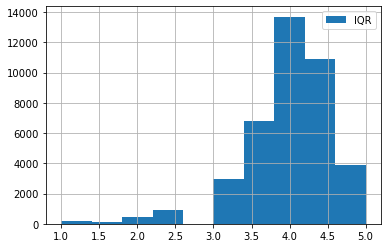

In [9]:
# начнем анализ с целевой переменной
column_info('Rating')

Позже, в разделе визуализации, рассмотрим распределение целевой переменной относительно других признаков.

Информация о столбце Ranking
Количество пустых строк: 0
Распределение столбца:          Ranking
1080.0        19
437.0         18
491.0         18
345.0         18
431.0         18
...          ...
14711.0        1
9409.0         1
14109.0        1
10501.0        1
5699.0         1

[11936 rows x 1 columns]
count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: Ranking, dtype: float64
25-й перцентиль: 973.0, 75-й перцентиль: 5260.0, IQR: 4287.0 Границы выбросов: [-5457.5,11690.5]




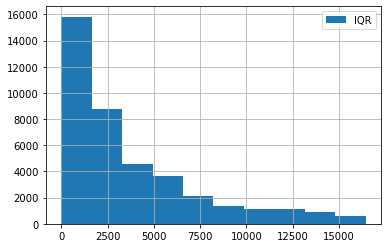

In [10]:
column_info('Ranking')

Вывод: столбец нормально распределен. Далее посмотрим на распределение 'Ranking' относительно других признаков.

Информация о столбце Number_of_Reviews
Количество пустых строк: 2543
Распределение столбца:         Number_of_Reviews
2.0                  1916
3.0                  1636
4.0                  1370
5.0                  1181
6.0                  1018
...                   ...
2141.0                  1
920.0                   1
1404.0                  1
979.0                   1
1698.0                  1

[1459 rows x 1 columns]
count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number_of_Reviews, dtype: float64
25-й перцентиль: 9.0, 75-й перцентиль: 115.0, IQR: 106.0 Границы выбросов: [-150.0,274.0]




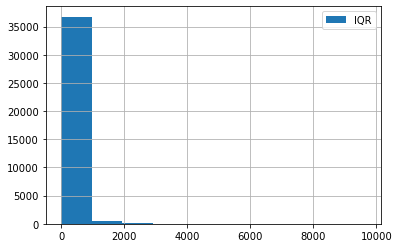

In [11]:
column_info('Number_of_Reviews')

In [12]:
# заполним пропуски самым частым значением
df['NAN_Number_of_Reviews'] = pd.isna(
    df['Number_of_Reviews']).astype('float64')
df['Number_of_Reviews'].fillna(df['Number_of_Reviews'].mode()[0], inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Restaurant_id          40000 non-null  object 
 1   City                   40000 non-null  object 
 2   Cuisine_Style          30717 non-null  object 
 3   Ranking                40000 non-null  float64
 4   Rating                 40000 non-null  float64
 5   Price_Range            26114 non-null  object 
 6   Number_of_Reviews      40000 non-null  float64
 7   Reviews                40000 non-null  object 
 8   URL_TA                 40000 non-null  object 
 9   ID_TA                  40000 non-null  object 
 10  NAN_Number_of_Reviews  40000 non-null  float64
dtypes: float64(4), object(7)
memory usage: 3.4+ MB


In [14]:
# распределение количества отзывов по городам
review_city = df.groupby(['City'])['Number_of_Reviews'].sum().sort_values(ascending=False)
review_city

City
London        746837.0
Rome          584101.0
Paris         561892.0
Milan         352843.0
Barcelona     337940.0
Madrid        292041.0
Prague        159327.0
Lisbon        153875.0
Amsterdam     152009.0
Edinburgh     134427.0
Berlin        130194.0
Budapest      119305.0
Dublin         99531.0
Vienna         89605.0
Brussels       88165.0
Lyon           73230.0
Munich         67431.0
Oporto         65049.0
Stockholm      59199.0
Athens         58117.0
Copenhagen     56570.0
Krakow         50091.0
Warsaw         42319.0
Hamburg        40728.0
Zurich         39233.0
Oslo           34783.0
Geneva         27863.0
Helsinki       21300.0
Luxembourg     16210.0
Bratislava     13783.0
Ljubljana      12676.0
Name: Number_of_Reviews, dtype: float64

Вывод: пропуски заполнили наиболее часто встречающимся значением, чем больше город, тем больше отзывов. Как видим, признак распределен неравномерно и его распределение сильно смещено вправо.

# Ознакомимся с категориальными признаками:

In [15]:
for column in df.columns:
    if df[column].dtypes == object:
        print(column_info(column))

Информация о столбце Restaurant_id
Количество пустых строк: 0
Распределение столбца:           Restaurant_id
id_871               18
id_633               18
id_227               18
id_436               18
id_71                17
...                 ...
id_3238               1
id_9820               1
id_15939              1
id_4323               1
id_13358              1

[11909 rows x 1 columns]
count      40000
unique     11909
top       id_871
freq          18
Name: Restaurant_id, dtype: object


None
Информация о столбце City
Количество пустых строк: 0
Распределение столбца:             City
London      5757
Paris       4897
Madrid      3108
Barcelona   2734
Berlin      2155
Milan       2133
Rome        2078
Prague      1443
Lisbon      1300
Vienna      1166
Amsterdam   1086
Brussels    1060
Hamburg      949
Munich       893
Lyon         892
Stockholm    820
Budapest     816
Warsaw       727
Dublin       673
Copenhagen   659
Athens       628
Edinburgh    596
Zurich       538
Oporto 

1. Restaurant_id

In [16]:
df['Restaurant_id'].value_counts()

id_871      18
id_633      18
id_227      18
id_436      18
id_71       17
            ..
id_3238      1
id_9820      1
id_15939     1
id_4323      1
id_13358     1
Name: Restaurant_id, Length: 11909, dtype: int64

In [17]:
# посмотрим, как выглядят уникальные значения в этом столбце
df_Restaurant_id = df[df['Restaurant_id'] == 'id_633']
df_Restaurant_id.sample(7)

,Restaurant_id,City,Cuisine_Style,Ranking,Rating,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,NAN_Number_of_Reviews
17540,id_633,Hamburg,['Brazilian'],634.0,4.0,$$ - $$$,36.0,"[['nice Brazilian reastaurent in Hamburg', 'Ru...",/Restaurant_Review-g187331-d10212208-Reviews-P...,d10212208,0.0
4359,id_633,Rome,"['Italian', 'Pizza', 'Fast Food', 'Mediterrane...",634.0,4.5,$,600.0,"[['Cheap, delicious, good service, quick', 'Gr...",/Restaurant_Review-g187791-d3190881-Reviews-Re...,d3190881,0.0
25848,id_633,Madrid,"['Mediterranean', 'Spanish']",634.0,4.5,$$ - $$$,149.0,"[['Best show in town!', 'Awsome flamenco class...",/Restaurant_Review-g187514-d4233083-Reviews-Ca...,d4233083,0.0
35323,id_633,Geneva,NaN,636.0,4.0,NaN,17.0,"[['Big food!!', 'De très bons tacos // Excelle...",/Restaurant_Review-g188057-d10250682-Reviews-S...,d10250682,0.0
35330,id_633,Prague,"['Bar', 'European', 'Pub', 'Czech', 'Eastern E...",634.0,4.0,$,199.0,"[['Fresh tank beers.', 'Great food, good beer'...",/Restaurant_Review-g274707-d1093686-Reviews-Ba...,d1093686,0.0
2927,id_633,Budapest,['Vegetarian Friendly'],634.0,4.5,$,18.0,"[['Good qualitybreakfast and lovely venue', 'G...",/Restaurant_Review-g274887-d12327467-Reviews-F...,d12327467,0.0
836,id_633,Milan,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",635.0,3.5,$$ - $$$,743.0,[['Sunshine of Italian pizza in Milan on a we....,/Restaurant_Review-g187849-d7660183-Reviews-Br...,d7660183,0.0


Вывод: непонятно,что делать с задвоенными данными, кажется, что удалить их как дубликаты будет нецелесообразным, так как они относятся к разным городам, удалим весь столбец.

In [18]:
df.drop(['Restaurant_id'], inplace = True, axis = 1)

2. City

In [19]:
df['City'].value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

In [ ]:
# здесь был код для изменения названия города Порту, но данное изменение ухудшает работу модели

In [20]:
# добавим dummies на каждый город 
df_City_dummies = pd.get_dummies(df['City'], dummy_na=False).astype('float64')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   40000 non-null  object 
 1   Cuisine_Style          30717 non-null  object 
 2   Ranking                40000 non-null  float64
 3   Rating                 40000 non-null  float64
 4   Price_Range            26114 non-null  object 
 5   Number_of_Reviews      40000 non-null  float64
 6   Reviews                40000 non-null  object 
 7   URL_TA                 40000 non-null  object 
 8   ID_TA                  40000 non-null  object 
 9   NAN_Number_of_Reviews  40000 non-null  float64
dtypes: float64(4), object(6)
memory usage: 3.1+ MB


In [22]:
# добавим признак столица или нет
list_not_capital = ['Barcelona', 'Milan', 'Hamburg', 'Munich', 
                          'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']
df['Capital_City'] = df['City'].apply(lambda x: 0 if x in list_not_capital else 1)

In [23]:
# добавим параметр население городов на 2020, информация 
# с сайта https://worldpopulationreview.com/world-cities
dict_population = {
    'London': 8908, 'Paris': 2206, 'Madrid': 3345, 'Barcelona': 1621,
    'Berlin': 3769, 'Milan': 1399, 'Rome': 2860, 'Prague': 1324,
    'Lisbon': 505, 'Vienna': 1888, 'Amsterdam': 872, 'Brussels': 179,
    'Hamburg': 1845, 'Munich': 1484, 'Lyon': 516, 'Stockholm': 975,
    'Budapest': 1768, 'Warsaw': 1790, 'Dublin': 553,
    'Copenhagen': 794, 'Athens': 665, 'Edinburgh': 536,
    'Zurich': 341, 'Oporto': 287, 'Geneva': 201, 'Krakow': 779,
    'Oslo': 697, 'Helsinki': 656, 'Bratislava': 432,
    'Luxembourg': 122, 'Ljubljana': 295
}
df['Сity_population'] = df.apply(
    lambda row: dict_population[row['City']], axis=1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   40000 non-null  object 
 1   Cuisine_Style          30717 non-null  object 
 2   Ranking                40000 non-null  float64
 3   Rating                 40000 non-null  float64
 4   Price_Range            26114 non-null  object 
 5   Number_of_Reviews      40000 non-null  float64
 6   Reviews                40000 non-null  object 
 7   URL_TA                 40000 non-null  object 
 8   ID_TA                  40000 non-null  object 
 9   NAN_Number_of_Reviews  40000 non-null  float64
 10  Capital_City           40000 non-null  int64  
 11  Сity_population        40000 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 3.7+ MB


In [25]:
# определим количество ресторанов в каждом городе
df['Rest_num'] = df['City'].apply(lambda x: dict_population[x])

In [26]:
df.sample(5)

,City,Cuisine_Style,Ranking,Rating,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,NAN_Number_of_Reviews,Capital_City,Сity_population,Rest_num
31356,London,"['Italian', 'Pizza', 'Vegetarian Friendly', 'V...",894.0,4.0,$$ - $$$,1207.0,"[['Nice Italian food', '50-50'], ['12/06/2017'...",/Restaurant_Review-g186338-d1018964-Reviews-Zi...,d1018964,0.0,1,8908,8908
35668,Vienna,"['Cafe', 'European', 'Vegetarian Friendly', 'V...",296.0,4.0,$$ - $$$,201.0,"[['Top notch Eggs Benedict', 'Breakfast favori...",/Restaurant_Review-g190454-d7389778-Reviews-Jo...,d7389778,0.0,1,1888,1888
14033,Krakow,"['Polish', 'European']",915.0,4.5,$,8.0,"[[""Like my mom's"", 'Lunch'], ['05/29/2016', '1...",/Restaurant_Review-g274772-d7627086-Reviews-Ba...,d7627086,0.0,0,779,779
5440,Milan,NaN,3417.0,5.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187849-d13296811-Reviews-G...,d13296811,1.0,0,1399,1399
14369,Paris,['French'],9251.0,4.5,NaN,4.0,"[[], []]",/Restaurant_Review-g187147-d4007146-Reviews-De...,d4007146,0.0,1,2206,2206


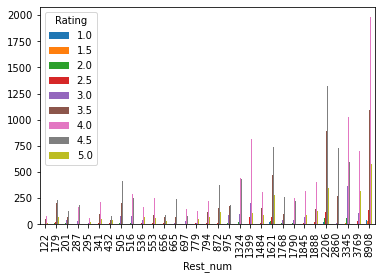

In [27]:
# посмотрим на влияние количества ресторанов в городе на рейтинг ресторана
ct = pd.crosstab([df.Rest_num], df['Rating'])
ct.plot(kind='bar')

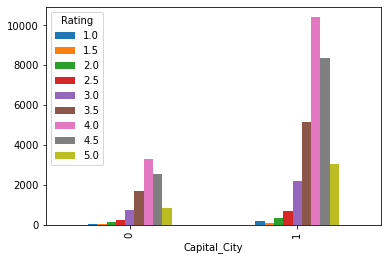

In [28]:
# посмотрим на влияние количества ресторанов в городе на рейтинг ресторана
ct = pd.crosstab([df.Capital_City], df['Rating'])
ct.plot(kind='bar')

Вывод: категориальный признак без пропусков, добавили новые признаки: dummies на каждый город(написание Порту не изменяли), 'Capital_City', определяющий является ли город столицей или нет, 'Population' с населением города, 'Rest_num' с кол-вом ресторанов в городах.
Видно, что количество ресторанов влияет на рейтинг: в городах, где много ресторанов отзывы выше среднего, а в городах, где ресторанов меньше оценка более критичная. Критерий "столица/нет" влияет на рейтинг, в столицах рейтинг выше. Возможно это связано с тем, что люди в столицах чаще ходят в ресторан и делятся своей оценкой.

3. Cuisine_Style

In [29]:
# обработаем столбец 'Cuisine_Style'
def str_to_list(string):
    if pd.isnull(string):
        return []
    else:
        string = string.replace('"', '')
        string = string.replace('[', '')
        string = string.replace(']', '')
        string = string.replace("'", '')
        return string.split(', ')

In [30]:
# преобразуем кухни в списки
df['Cuisine_Style_list'] = df['Cuisine_Style'].apply(str_to_list)

In [31]:
# посчитаем количество видов кухонь 
cuisines = set()
for cuisine_list in df['Cuisine_Style_list']:
    for cuisine in cuisine_list:
        cuisines.add(cuisine)

len(cuisines)

125

In [32]:
# ищем самый часто встречающийся вид кухни
cuisine_count = dict.fromkeys(cuisines, 0)
for cuisine in cuisines:
    for cuisine_list in df['Cuisine_Style_list']:
        if cuisine in cuisine_list:
            cuisine_count[cuisine] += 1

cuisine_count = pd.Series(cuisine_count)
cuisine_count.sort_values(ascending=False)

Vegetarian Friendly    11189
European               10060
Mediterranean           6277
Italian                 5964
Vegan Options           4486
                       ...  
Burmese                    1
Latvian                    1
Xinjiang                   1
Salvadoran                 1
Yunnan                     1
Length: 125, dtype: int64

In [33]:
# сохраним информацию о пропусках
df['NAN_Cuisine Style'] = pd.isna(df['Cuisine_Style']).astype('float64') 

# заполним пропуски значением 'Other'
df['Cuisine_Style'] = df['Cuisine_Style'].fillna("['Other']")

In [34]:
# добавим признак количество кухонь в ресторане
df['Count_Cuisine_Style'] = df['Cuisine_Style'].apply(
    lambda x: len(x)).astype('float64')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   40000 non-null  object 
 1   Cuisine_Style          40000 non-null  object 
 2   Ranking                40000 non-null  float64
 3   Rating                 40000 non-null  float64
 4   Price_Range            26114 non-null  object 
 5   Number_of_Reviews      40000 non-null  float64
 6   Reviews                40000 non-null  object 
 7   URL_TA                 40000 non-null  object 
 8   ID_TA                  40000 non-null  object 
 9   NAN_Number_of_Reviews  40000 non-null  float64
 10  Capital_City           40000 non-null  int64  
 11  Сity_population        40000 non-null  int64  
 12  Rest_num               40000 non-null  int64  
 13  Cuisine_Style_list     40000 non-null  object 
 14  NAN_Cuisine Style      40000 non-null  float64
 15  Co

Вывод:  было много пропусков, преобразовали данные в список, создали новый признак 'NAN_Cuisine_Style', добавлен критерий количества типов кухонь в ресторане 'Count_Cuisine_Style'. Всего 125 кухонь, а самая популярная кухня Vegetarian Friendly.

4. Price_Range

In [36]:
df['Price_Range'].value_counts(dropna = False)

$$ - $$$    18412
NaN         13886
$            6279
$$$$         1423
Name: Price_Range, dtype: int64

In [37]:
# сохраним информацию о пропусках
df['NaN_Price'] = pd.isna(df['Price_Range']).astype('float64')

In [38]:
# присвоим значения каждой ценовой категории
price_to_num = {'$': 0, '$$ - $$$': 1, '$$$$': 2}
df['Price_Range'] = df['Price_Range'].fillna(1)
df['Price_Range'] = df['Price_Range'].replace(to_replace=price_to_num)
df.head()

,City,Cuisine_Style,Ranking,Rating,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,NAN_Number_of_Reviews,Capital_City,Сity_population,Rest_num,Cuisine_Style_list,NAN_Cuisine Style,Count_Cuisine_Style,NaN_Price
0,Paris,"['European', 'French', 'International']",5570.0,3.5,1,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0.0,1,2206,2206,"[European, French, International]",0.0,39.0,0.0
1,Stockholm,['Other'],1537.0,4.0,1,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,0.0,1,975,975,[],1.0,9.0,1.0
2,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,2,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,0.0,1,8908,8908,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",0.0,102.0,0.0
3,Berlin,['Other'],3458.0,5.0,1,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,0.0,1,3769,3769,[],1.0,9.0,1.0
4,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,1,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,0.0,0,1484,1484,"[German, Central European, Vegetarian Friendly]",0.0,53.0,0.0


In [39]:
df['Price_Range'].value_counts()

1    32298
0     6279
2     1423
Name: Price_Range, dtype: int64

Вывод: было много пропусков, информацию о них сохранили в 'NaN_Price Range'. Для заполнения пропусков создали словарь: низкая цена - 0, средняя цена - 1 , высокая цена - 2(изначально пробовали значения 1,2,3). Пропуски заполнили наиболее часто встречающимся значением.

5. Reviews

In [40]:
df["Reviews"].value_counts()

[[], []]                                                                                                      6471
[['The real codido madrileño'], ['03/31/2017']]                                                                  2
[['Absolutely authentic and delicious!', 'Wonderful discovery'], ['09/30/2017', '08/04/2016']]                   2
[['Great food, service and atmosphere', 'Decor and food'], ['11/06/2017', '10/22/2017']]                         2
[['Thursday snack', 'Good value for money & good food!'], ['03/13/2017', '06/20/2016']]                          2
                                                                                                              ... 
[['Healthy lunch', 'Great organic lunch!'], ['10/07/2017', '01/16/2017']]                                        1
[['Quiet, non smoking, central, love it', 'Good ambiance but limited menu'], ['05/20/2012', '04/12/2012']]       1
[['Popular Real Ale Pub', 'Great pub'], ['12/17/2017', '12/09/2017']]           

In [41]:
# обработка для Reviews
def review_to_list(string):
    if string == '[[], []]':
        return []
    else:
        string = string.replace(']]', '')
        string = string.replace("'", '')
        string = string.split('], [')[1]
        string = string.split(', ')
        return string

In [42]:
df["NAN_Reviews"] = pd.isna(df["Reviews"]).astype("uint8")
df["Reviews"].fillna("[[], []]", inplace=True)

In [43]:
df['Reviews_date_temp'] = df['Reviews'].apply(review_to_list)

In [44]:
# найдем дату в отзывах и создадим новые критерии
df['date_of_Review'] = df['Reviews'].str.findall('\d+/\d+/\d+')
df['len_date'] = df['date_of_Review'].apply(lambda x: len(x))

In [45]:
df['len_date']

0        2
1        2
2        2
3        0
4        2
        ..
39995    2
39996    2
39997    2
39998    2
39999    2
Name: len_date, Length: 40000, dtype: int64

In [46]:
# определим дату первого отзыва
df['Reviews_date_first'] = df['Reviews_date_temp'].apply(
    lambda x: None if len(x) == 0
    else pd.to_datetime(x[0], format='%m/%d/%Y') if len(x) == 1
    else pd.to_datetime(x[0], format='%m/%d/%Y') if pd.to_datetime(x[0], format='%m/%d/%Y') < pd.to_datetime(x[1], format='%m/%d/%Y')
    else pd.to_datetime(x[1], format='%m/%d/%Y'))

# определим дату последнего отзыва
df['Reviews_date_last'] = df['Reviews_date_temp'].apply(
    lambda x: None if len(x) == 0
    else pd.to_datetime(x[0], format='%m/%d/%Y') if len(x) == 1
    else pd.to_datetime(x[0], format='%m/%d/%Y') if pd.to_datetime(x[0], format='%m/%d/%Y') > pd.to_datetime(x[1], format='%m/%d/%Y')
    else pd.to_datetime(x[1], format='%m/%d/%Y'))

In [47]:
min_date = df['Reviews_date_first'].mean()
max_date = df['Reviews_date_last'].mean()

In [48]:
# заполним пропуски в датах самой ранней датой
df['Reviews_date_first'].fillna(min_date, inplace=True)

# заполним пустые значения последней даты значением самой ранней даты
df.loc[pd.isnull(df['Reviews_date_last']),
       'Reviews_date_last'] = df['Reviews_date_first']

In [49]:
# вводим параметр - кол-во дней между отзывами
df['days_between_Reviews'] = (df['Reviews_date_last'] - df['Reviews_date_first']).dt.days

In [50]:
df.sample(5)

,City,Cuisine_Style,Ranking,Rating,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,NAN_Number_of_Reviews,...,NAN_Cuisine Style,Count_Cuisine_Style,NaN_Price,NAN_Reviews,Reviews_date_temp,date_of_Review,len_date,Reviews_date_first,Reviews_date_last,days_between_Reviews
36966,Berlin,"['Fast Food', 'Middle Eastern']",4589.0,4.5,1,4.0,"[['Delicious food'], ['11/06/2016']]",/Restaurant_Review-g187323-d3842063-Reviews-Pr...,d3842063,0.0,...,0.0,31.0,1.0,0,[11/06/2016],[11/06/2016],1,2016-11-06 00:00:00.000000000,2016-11-06 00:00:00.000000000,0
36861,Berlin,['International'],3079.0,4.5,1,5.0,"[['How come I didn’t go sooner?', 'Small but v...",/Restaurant_Review-g187323-d10218950-Reviews-M...,d10218950,0.0,...,0.0,17.0,0.0,0,"[10/31/2017, 06/05/2017]","[10/31/2017, 06/05/2017]",2,2017-06-05 00:00:00.000000000,2017-10-31 00:00:00.000000000,148
25664,Madrid,['Other'],5863.0,4.0,1,2.0,"[[], []]",/Restaurant_Review-g187514-d8097734-Reviews-Ru...,d8097734,0.0,...,1.0,9.0,1.0,0,[],[],0,2017-01-10 04:16:05.898190336,2017-01-10 04:16:05.898190336,0
10249,Madrid,['Other'],4208.0,5.0,1,3.0,"[[], []]",/Restaurant_Review-g187514-d5870127-Reviews-Me...,d5870127,0.0,...,1.0,9.0,1.0,0,[],[],0,2017-01-10 04:16:05.898190336,2017-01-10 04:16:05.898190336,0
7444,Brussels,['Other'],1935.0,4.5,1,13.0,[['A taste of the Carribean in the heart of B....,/Restaurant_Review-g188644-d6360325-Reviews-Ca...,d6360325,0.0,...,1.0,9.0,1.0,0,"[06/18/2015, 04/13/2015]","[06/18/2015, 04/13/2015]",2,2015-04-13 00:00:00.000000000,2015-06-18 00:00:00.000000000,66


In [51]:
# формируем списки слов:

positive_words = ['good', 'very nice', 'most', 'great', 'nice', 'best', 'excellent',
                  'delicious', 'lovely', 'ok', 'local', 'perfect', 'fast', 'fine',
                  'authentic', 'amazing','delightful', 'outstanding',
                  'tasty', 'friendly', 'beautiful', 'well', 'top', 'awesome', 'cozy',
                  'fantastic', 'quick', 'perfect', 'generous', 'wonderful', 'favourite',
                  'yummy','super', 'top quality', 'popular'
                  'underrated', 'magic', 'highly reccomended', 'cool', 'traditional',
                  'unique', 'heaven', 'pleasantly surprised']
                  


negative_words = ['poor','too busy', 'horrible', 'awful' 'worst', 'nasty', 'terrible',
                  'disappointing','avoid','average', 'tourist trap','slow', 
                  'overpriced', 'unfriendly', 'rude', 'bad']
                  

In [52]:
# определим, есть ли у отзыва позитивный окрас 
df['Review_pos'] = df['Reviews'].apply(
        lambda x: 1 if any([y in x.lower() for y in positive_words])  else 0)

In [53]:
# определим, есть ли у отзыва негативный окрас 
df['Review_neg'] = df['Reviews'].apply(
        lambda x: 1 if any([y in x.lower() for y in negative_words])  else 0)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   City                   40000 non-null  object        
 1   Cuisine_Style          40000 non-null  object        
 2   Ranking                40000 non-null  float64       
 3   Rating                 40000 non-null  float64       
 4   Price_Range            40000 non-null  int64         
 5   Number_of_Reviews      40000 non-null  float64       
 6   Reviews                40000 non-null  object        
 7   URL_TA                 40000 non-null  object        
 8   ID_TA                  40000 non-null  object        
 9   NAN_Number_of_Reviews  40000 non-null  float64       
 10  Capital_City           40000 non-null  int64         
 11  Сity_population        40000 non-null  int64         
 12  Rest_num               40000 non-null  int64         
 13  C

In [55]:
df.sample(5)

,City,Cuisine_Style,Ranking,Rating,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,NAN_Number_of_Reviews,...,NaN_Price,NAN_Reviews,Reviews_date_temp,date_of_Review,len_date,Reviews_date_first,Reviews_date_last,days_between_Reviews,Review_pos,Review_neg
22373,Berlin,['Other'],5321.0,4.0,1,4.0,"[['It used to be better'], ['08/31/2014']]",/Restaurant_Review-g187323-d7045749-Reviews-Gr...,d7045749,0.0,...,1.0,0,[08/31/2014],[08/31/2014],1,2014-08-31,2014-08-31,0,0,0
28820,Prague,"['Italian', 'Mediterranean']",982.0,4.5,1,23.0,"[['Great pizza', 'Great restaurant, lots of ch...",/Restaurant_Review-g274707-d4769645-Reviews-Pa...,d4769645,0.0,...,0.0,0,"[10/28/2017, 03/25/2017]","[10/28/2017, 03/25/2017]",2,2017-03-25,2017-10-28,217,1,0
15289,London,"['Lebanese', 'Fast Food', 'Middle Eastern', 'H...",5570.0,4.0,0,71.0,"[['Quick awesome food', 'Best shawarma but hor...",/Restaurant_Review-g186338-d4834267-Reviews-Ca...,d4834267,0.0,...,0.0,0,"[12/29/2017, 06/20/2017]","[12/29/2017, 06/20/2017]",2,2017-06-20,2017-12-29,192,1,1
15496,Prague,['Pub'],2945.0,4.0,1,11.0,"[['Good Lunch', 'Delicious dinner!'], ['09/04/...",/Restaurant_Review-g274707-d4769026-Reviews-Pa...,d4769026,0.0,...,1.0,0,"[09/04/2017, 10/10/2016]","[09/04/2017, 10/10/2016]",2,2016-10-10,2017-09-04,329,1,0
23049,Prague,['Vietnamese'],1700.0,4.5,0,15.0,"[['Great takeaway', 'very nice place'], ['02/2...",/Restaurant_Review-g274707-d7124055-Reviews-Mr...,d7124055,0.0,...,0.0,0,"[02/21/2017, 01/17/2017]","[02/21/2017, 01/17/2017]",2,2017-01-17,2017-02-21,35,1,0


In [56]:
# удалим лишние столбцы, на основе которых работали с датами
df.drop(['Reviews_date_temp', 'Reviews_date_first','Reviews_date_last'], axis=1, inplace=True)

Вывод: поработали с датами и количеством отзывов - важный признак, сформированы списки слов для определения характера отзыва(этот параметр хотелось бы обработать не вручную, более подробно), но этот признак не особо значительный.

6. URL_TA

In [57]:
df['URL_TA'].value_counts()

/Restaurant_Review-g187514-d7809594-Reviews-La_Guapa-Madrid.html                                    2
/Restaurant_Review-g187514-d4600226-Reviews-Cafeteria_Teresa-Madrid.html                            2
/Restaurant_Review-g187514-d10047799-Reviews-Entrepuntos-Madrid.html                                2
/Restaurant_Review-g187514-d7337366-Reviews-Lady_Madonna-Madrid.html                                2
/Restaurant_Review-g187514-d8753348-Reviews-Tropecientos-Madrid.html                                2
                                                                                                   ..
/Restaurant_Review-g187147-d719796-Reviews-Orient_Extreme_St_Germain-Paris_Ile_de_France.html       1
/Restaurant_Review-g274707-d3640421-Reviews-My_Darling_Clementine_Restaurant-Prague_Bohemia.html    1
/Restaurant_Review-g187147-d10040334-Reviews-Comics_Burger-Paris_Ile_de_France.html                 1
/Restaurant_Review-g187497-d717375-Reviews-Punjab_Restaurante-Barcelona_Catalonia.

In [58]:
# рассмотрим пример дубликата
df_ID_TA = df[df['URL_TA'] == '/Restaurant_Review-g187514-d1315077-Reviews-El_Pimiento_Verde-Madrid.html']
df_ID_TA

,City,Cuisine_Style,Ranking,Rating,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,NAN_Number_of_Reviews,...,Cuisine_Style_list,NAN_Cuisine Style,Count_Cuisine_Style,NaN_Price,NAN_Reviews,date_of_Review,len_date,days_between_Reviews,Review_pos,Review_neg
10439,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",469.0,4.0,1,355.0,"[['Very good all around', 'Our first Madrid re...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077,0.0,...,"[Mediterranean, Spanish, Vegetarian Friendly, ...",0.0,74.0,0.0,0,"[11/20/2017, 10/11/2017]",2,40,1,0
25785,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",512.0,4.0,1,355.0,"[['Very good all around', 'Our first Madrid re...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077,0.0,...,"[Mediterranean, Spanish, Vegetarian Friendly, ...",0.0,74.0,0.0,0,"[11/20/2017, 10/11/2017]",2,40,1,0


Вывод: непонятно, почему строки задвоены, отличается только 'Ranking', возможно так помечены ресторанные сети? столбец не особо информативен, поэтому удалим дубликаты, а потом и столбец.

7. ID_TA

In [59]:
df['ID_TA'].value_counts()

d7809594     2
d793170      2
d11698990    2
d13002276    2
d1315077     2
            ..
d697019      1
d3180656     1
d2098316     1
d1392601     1
d3253049     1
Name: ID_TA, Length: 39980, dtype: int64

In [60]:
df.sample()

,City,Cuisine_Style,Ranking,Rating,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,NAN_Number_of_Reviews,...,Cuisine_Style_list,NAN_Cuisine Style,Count_Cuisine_Style,NaN_Price,NAN_Reviews,date_of_Review,len_date,days_between_Reviews,Review_pos,Review_neg
4902,Prague,"['American', 'Fast Food']",3675.0,3.0,1,3.0,"[[], []]",/Restaurant_Review-g274707-d7123488-Reviews-Ka...,d7123488,0.0,...,"[American, Fast Food]",0.0,25.0,1.0,0,[],0,0,0,0


In [61]:
# также есть повторяющиеся значения, посмотрим на пример такого
df_ID_TA = df[df['ID_TA'] == 'd8753348']
df_ID_TA

,City,Cuisine_Style,Ranking,Rating,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,NAN_Number_of_Reviews,...,Cuisine_Style_list,NAN_Cuisine Style,Count_Cuisine_Style,NaN_Price,NAN_Reviews,date_of_Review,len_date,days_between_Reviews,Review_pos,Review_neg
13942,Madrid,['Spanish'],1104.0,4.5,1,73.0,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348,0.0,...,[Spanish],0.0,11.0,0.0,0,[12/20/2017],1,0,1,0
31238,Madrid,['Spanish'],1213.0,4.5,1,73.0,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348,0.0,...,[Spanish],0.0,11.0,0.0,0,[12/20/2017],1,0,1,0


In [62]:
# посмотрим на дубликаты по городам
df[(df['ID_TA'].map(df['ID_TA'].value_counts()) == 2)].sort_values(by='ID_TA').City.value_counts()

Madrid    40
Name: City, dtype: int64

Вывод: такая же ситуация с дубликатами, дубликаты есть в Мадриде, удалим весь столбец.

In [63]:
df.drop(columns=['ID_TA'], inplace=True)
df.drop(columns=['URL_TA'], inplace=True)

# Визуализация

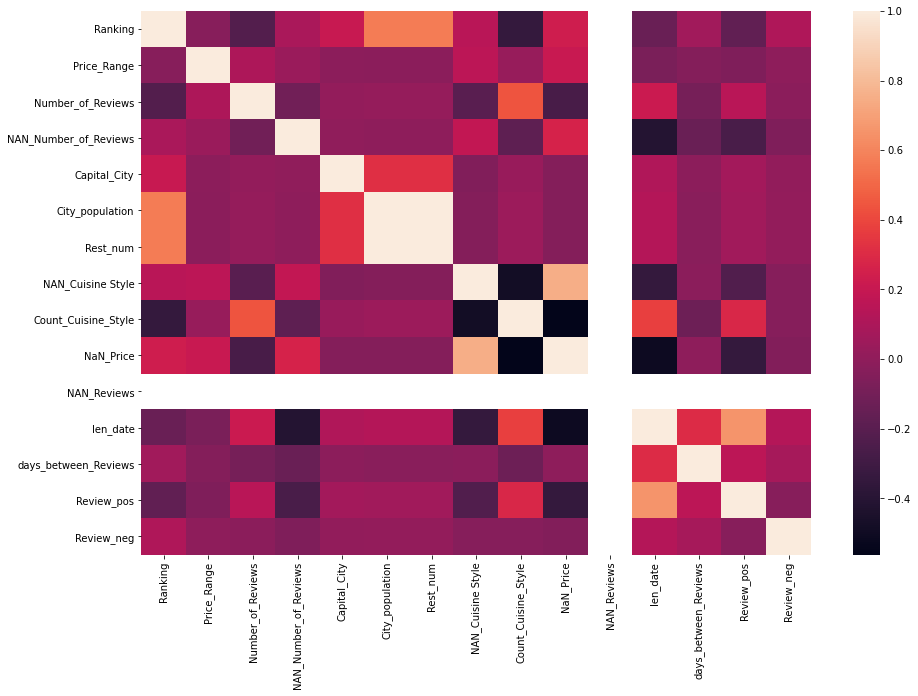

In [64]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['Rating'], axis=1).corr(),)

In [65]:
df.corr()

,Ranking,Rating,Price_Range,Number_of_Reviews,NAN_Number_of_Reviews,Capital_City,Сity_population,Rest_num,NAN_Cuisine Style,Count_Cuisine_Style,NaN_Price,NAN_Reviews,len_date,days_between_Reviews,Review_pos,Review_neg
Ranking,1.000000,-0.368371,-0.026525,-0.221952,0.094078,0.202251,0.571674,0.571674,0.147995,-0.344941,0.233043,NaN,-0.139749,0.065661,-0.168295,0.110987
Rating,-0.368371,1.000000,-0.028588,0.026943,0.008386,0.020758,-0.024558,-0.024558,-0.038263,0.136916,-0.064567,NaN,0.020524,-0.065990,0.145568,-0.235307
Price_Range,-0.026525,-0.028588,1.000000,0.107250,0.040268,-0.008270,-0.017683,-0.017683,0.158268,0.024178,0.209937,NaN,-0.076348,-0.039184,-0.060546,-0.001259
Number_of_Reviews,-0.221952,0.026943,0.107250,1.000000,-0.104176,0.013471,0.022234,0.022234,-0.201031,0.442387,-0.266392,NaN,0.213245,-0.086830,0.149102,-0.015838
NAN_Number_of_Reviews,0.094078,0.008386,0.040268,-0.104176,1.000000,0.001391,-0.004098,-0.004098,0.186118,-0.177546,0.266923,NaN,-0.410995,-0.134675,-0.259080,-0.056705
Capital_City,0.202251,0.020758,-0.008270,0.013471,0.001391,1.000000,0.317011,0.317011,-0.053798,0.033670,-0.042666,NaN,0.119335,-0.006912,0.066806,0.008214
Сity_population,0.571674,-0.024558,-0.017683,0.022234,-0.004098,0.317011,1.000000,1.000000,-0.041864,0.046791,-0.039081,NaN,0.133503,-0.020638,0.063018,0.017228
Rest_num,0.571674,-0.024558,-0.017683,0.022234,-0.004098,0.317011,1.000000,1.000000,-0.041864,0.046791,-0.039081,NaN,0.133503,-0.020638,0.063018,0.017228
NAN_Cuisine Style,0.147995,-0.038263,0.158268,-0.201031,0.186118,-0.053798,-0.041864,-0.041864,1.000000,-0.483018,0.753881,NaN,-0.345494,-0.013625,-0.230935,-0.030967
Count_Cuisine_Style,-0.344941,0.136916,0.024178,0.442387,-0.177546,0.033670,0.046791,0.046791,-0.483018,1.000000,-0.561499,NaN,0.376539,-0.124417,0.283155,-0.031661


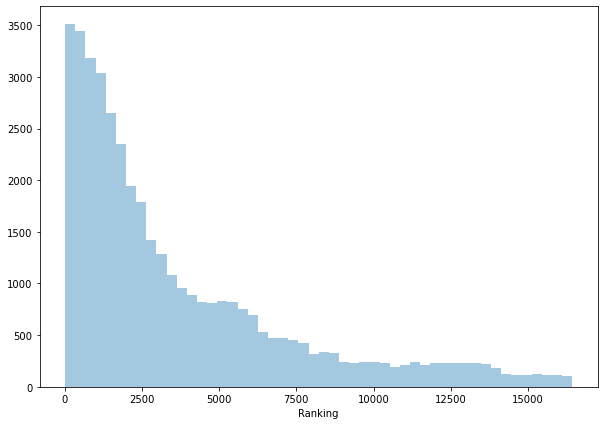

In [66]:
plt.rcParams["figure.figsize"] = (10, 7)
sns.distplot(df["Ranking"], kde=False)
plt.show()

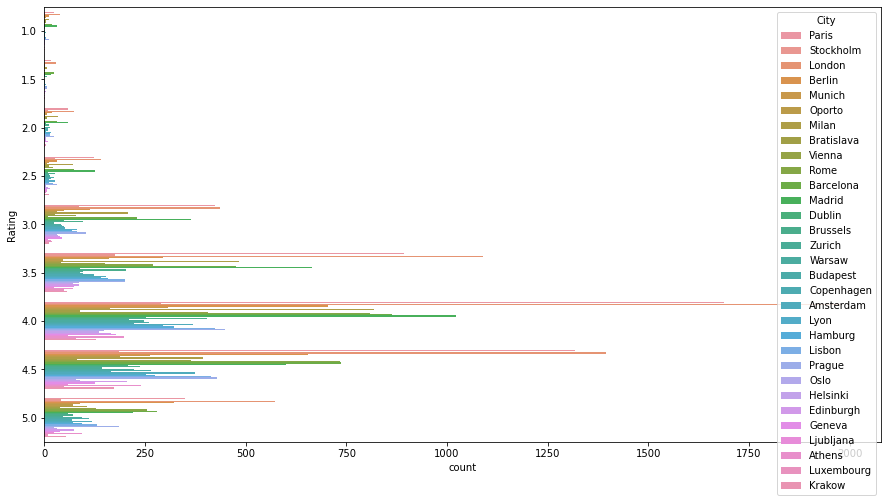

In [67]:
# попробуем посмотреть на распределение 'Rating' в зависимости от города
plt.figure(figsize=(15,8))
sns.countplot(y='Rating', hue='City',data=df)

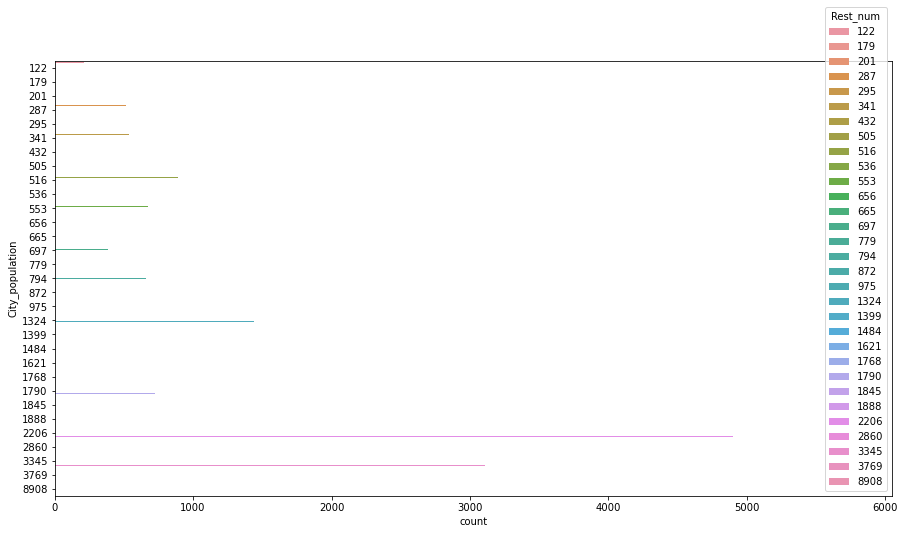

In [68]:
# попробуем посмотреть, как распределено количество количество ресторанов по 
# количеству населения в городах.

plt.figure(figsize=(15, 8))
sns.countplot(y='Сity_population', hue='Rest_num', data=df)

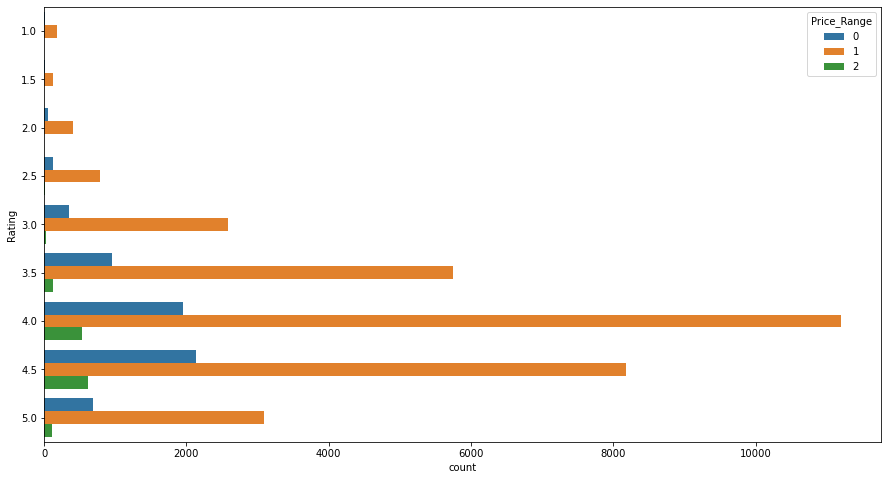

In [69]:
# попробуем посмотреть на распределение 'Rating' в зависимости от цены
plt.figure(figsize=(15,8))
sns.countplot(y='Rating', hue='Price_Range',data=df)

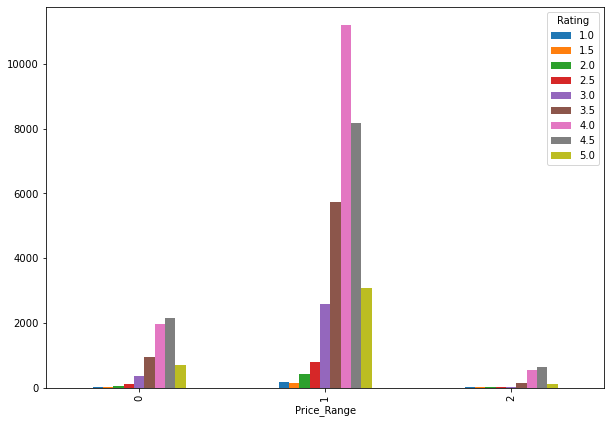

In [70]:
# влияние ценновой категории ресторана на рейтинг
ct = pd.crosstab([df.Price_Range], df['Rating'])
ct.plot(kind='bar')

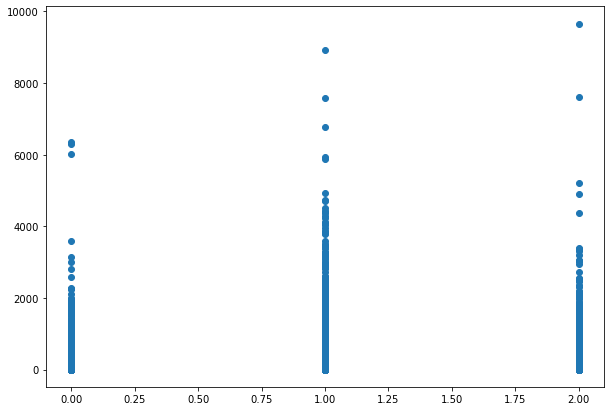

In [71]:
# связь ценновой категории ресторана и количества отзывов
plt.scatter(df['Price_Range'], df['Number_of_Reviews'])

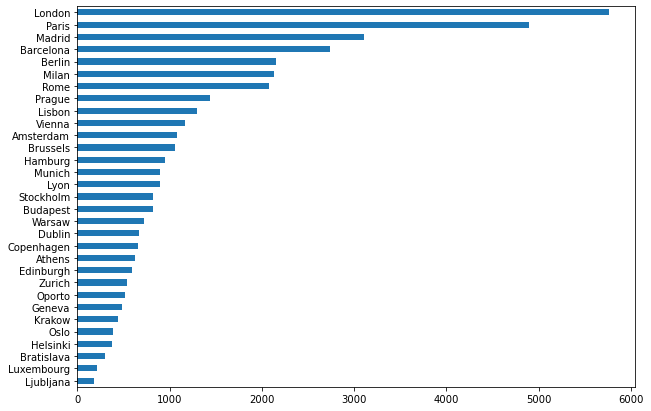

In [72]:
df['City'].value_counts(ascending=True).plot(kind='barh')

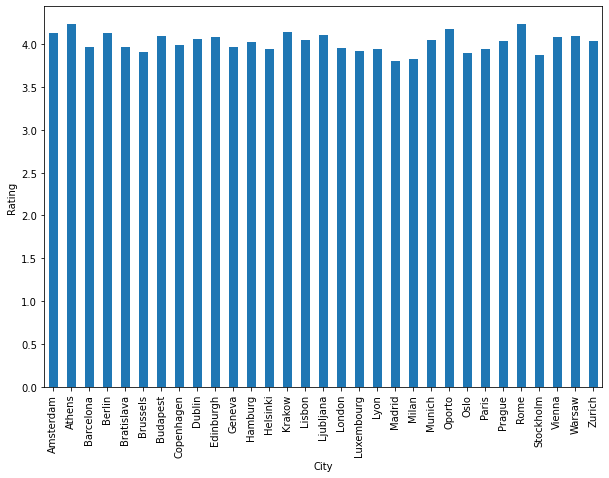

In [73]:
# посмотрим рейниг по городам
df.groupby('City')['Rating'].mean().plot(kind='bar') 
plt.ylabel('Rating')
plt.show()

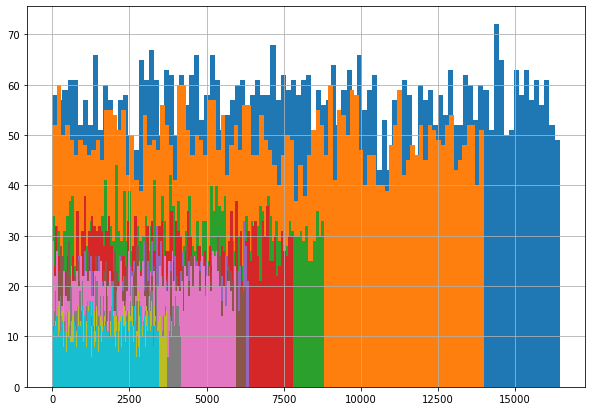

In [74]:
# посмотрим на топ 10 городов
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

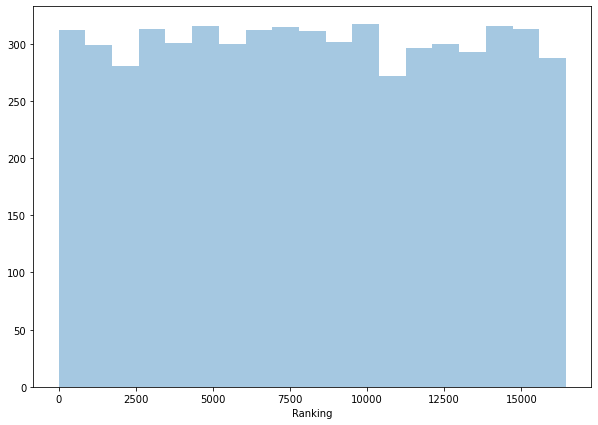

In [75]:
# распределение по Лондону
sns.distplot(df["Ranking"][df["City"] == "London"], kde=False)
plt.show()

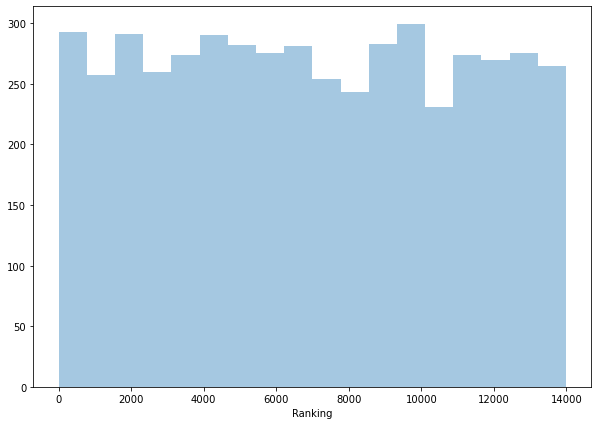

In [76]:
# распределение по Парижу
sns.distplot(df["Ranking"][df["City"] == "Paris"], kde=False)
plt.show()

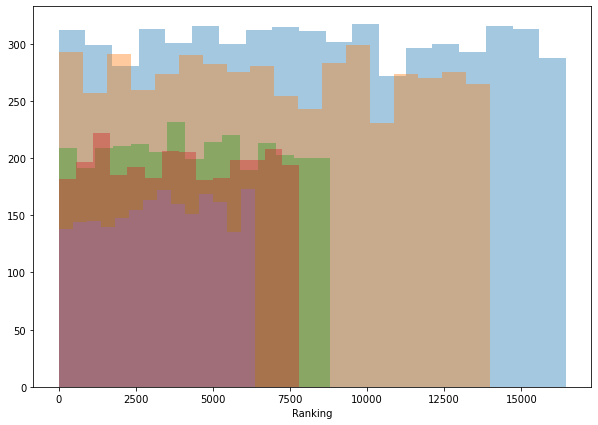

In [77]:
for x in (df["City"].value_counts())[0:5].index:
    sns.distplot(df["Ranking"][df["City"] == x], kde=False)
plt.show()

Ranking распределен равномерно, но в больших городах больше ресторанов, из-за этого появляется смещение.

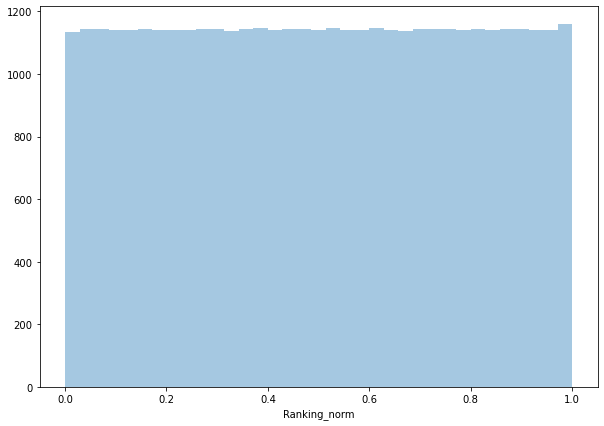

In [78]:
# нормализуем столбец Ranking в зависимости от города и добавим признак в датасет
df["Ranking_norm"] = df.groupby("City")["Ranking"].rank(pct=True)
sns.distplot(df["Ranking_norm"], kde=False)
plt.show()

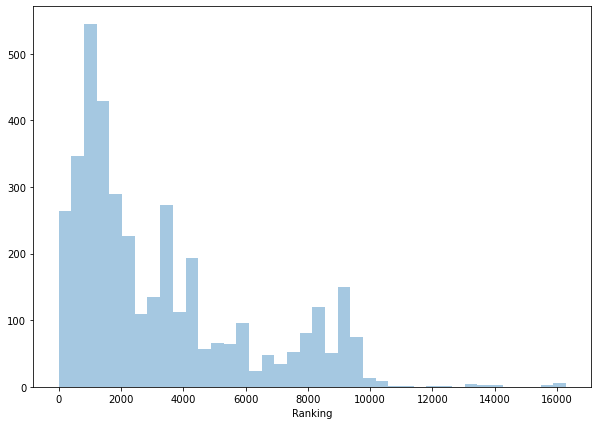

In [79]:
# распределение Ranking в случае наивысшего рейтинга
sns.distplot(df[df["Rating"] == 5]["Ranking"], kde=False)
plt.show()

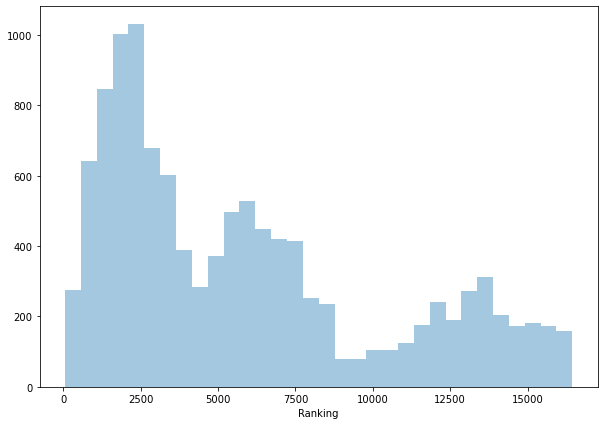

In [80]:
# распределение Ranking, в случае, когда рейтинг меньше 4
sns.distplot(df[(df["Rating"] < 4)]["Ranking"], kde=False)
plt.show()

In [81]:
df = df.loc[df['Rating'] != 2]

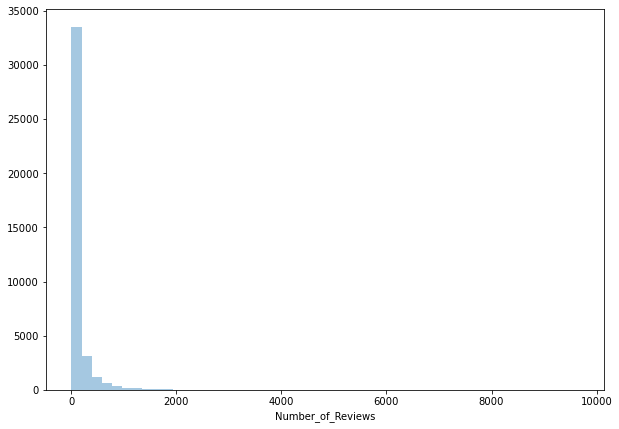

In [82]:
# посмотрим на распределение признака
sns.distplot(df["Number_of_Reviews"], kde=False)
plt.show()

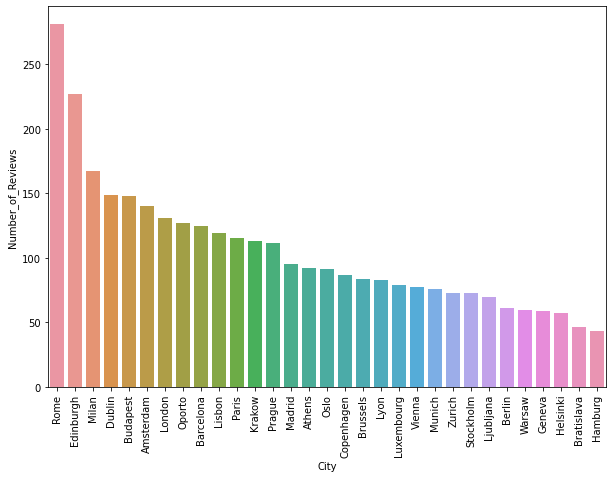

In [83]:
# посмотрим, какое среднее значение количества отзывов в зависимости от города
mean_num_of_reviews = df.groupby(
    "City")["Number_of_Reviews"].mean().sort_values(ascending=False)
ax = sns.barplot(mean_num_of_reviews.index, mean_num_of_reviews)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [84]:
# посмотрим, различаются ли распределения 'Rating' в зависимости от значения
# переменных с помощью box-plot


def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='Rating',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:29])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [85]:
variables = ['City','Cuisine_Style', 'Ranking', 'Price_Range', 'Number_of_Reviews',
        'Count_Cuisine_Style','Capital_City', 'Сity_population']

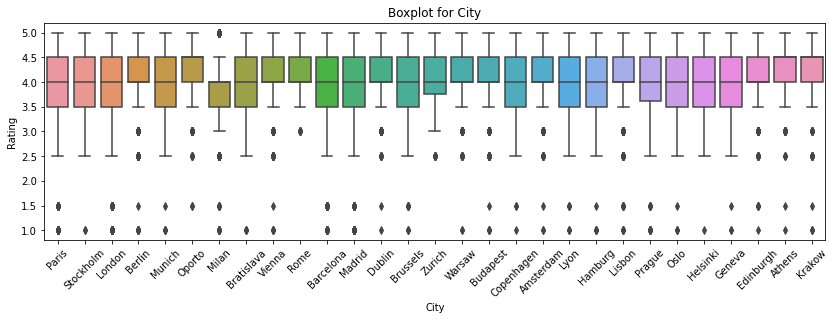

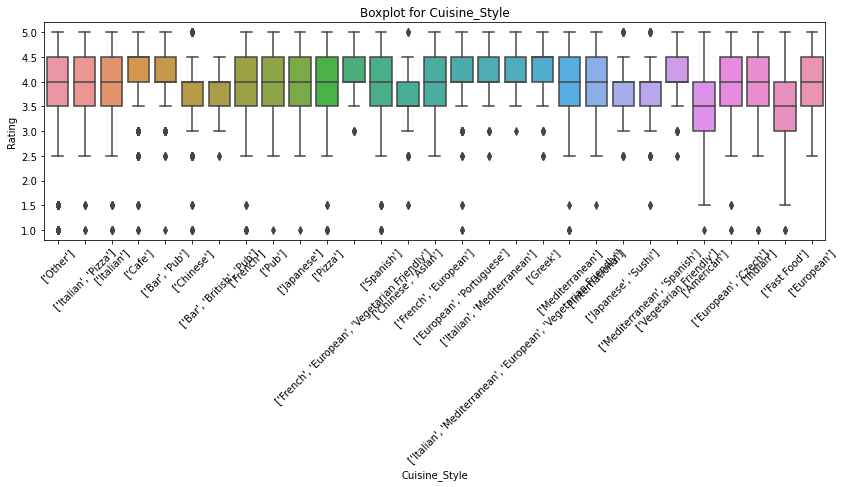

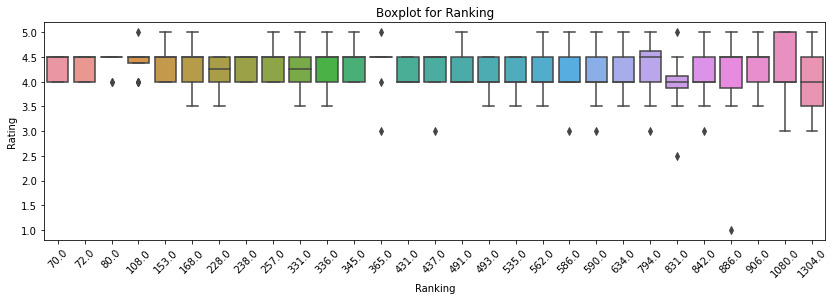

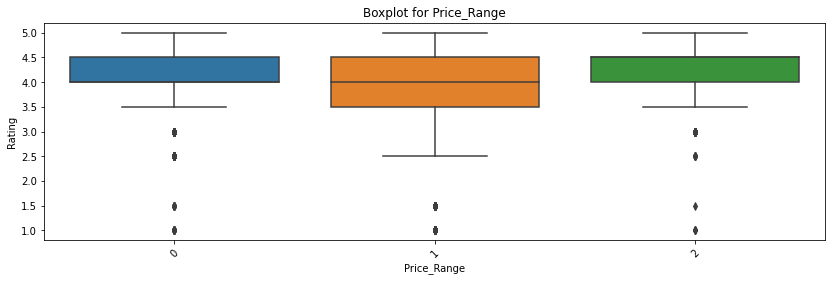

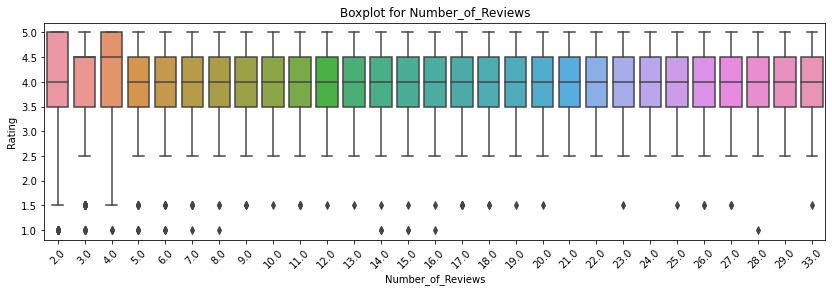

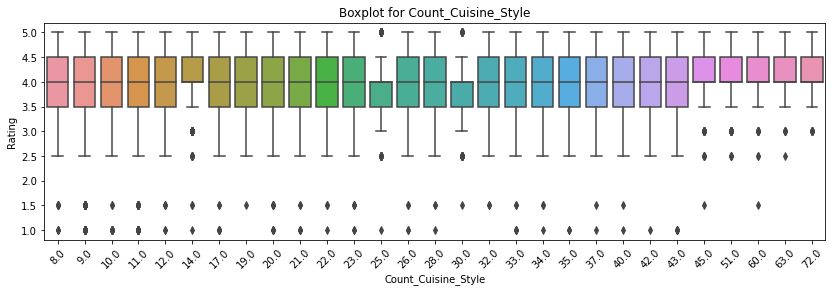

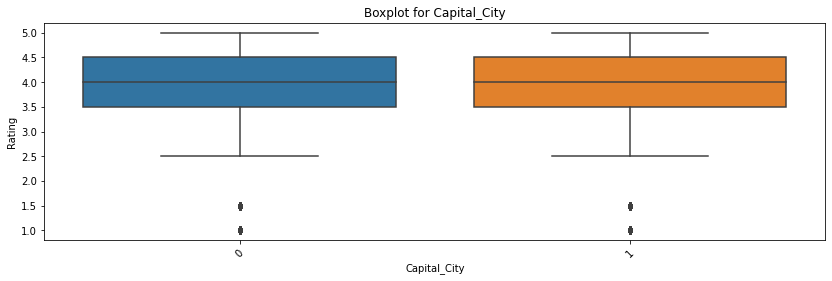

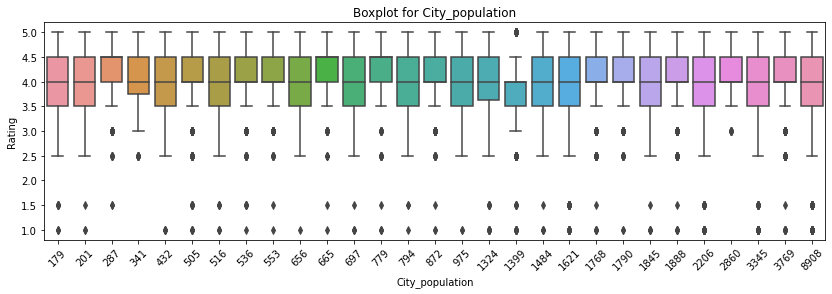

In [86]:
for col in variables:
    get_boxplot(col)

Вывод: чем больше город, тем выше рейтинг, больше отзывов, ценовый сегмент ресторана не особо влияет на рейтинг, Ranking имеет нормальное распределение, но в крупных городах больше ресторанов, из-за этого есть смещение, поэтому ввели признак 'Ranking_norm' и тем самым нормализовали столбец Ranking в зависимости от города, наибольшая корреляция у признаков: 'Сity_population', 'Rest_num', наибольшее количество отзывов в Риме, понятно почему итальянская кухня/блюда трижды в топе.

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [87]:

# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['City','Cuisine_Style','Reviews','Cuisine_Style_list', 'date_of_Review', 'Rating'], axis = 1)
y = df['Rating']

In [88]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [89]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [90]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [91]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [92]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2090439093484419
